## Pneumonia Detection using Deep Learning

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
from keras.models import load_model

### Load the dataset

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))     # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [3]:
train = get_data('dataset/train')
test = get_data('dataset/test')
val = get_data('dataset/val')

/tmp/ipykernel_6338/892617861.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


### Visualize the data for the pneumonia

In [4]:
pneumonia = os.listdir("dataset/train/PNEUMONIA")
pneumonia_dir = "dataset/train/PNEUMONIA"

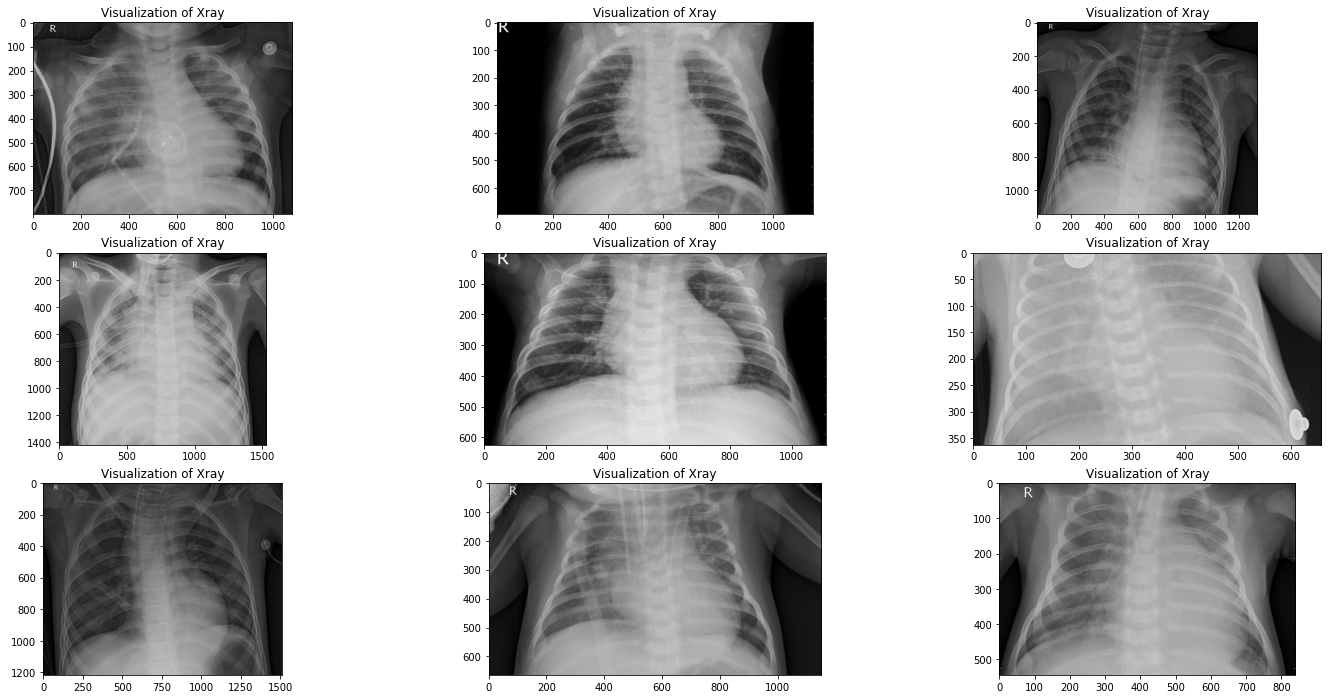

In [5]:
plt.figure(figsize = (25,12))
for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.title("Visualization of Xray")
plt.show()

### Visualize the data for the Normal Xray

In [6]:
normal = os.listdir("dataset/train/NORMAL")
normal_dir = "dataset/train/NORMAL"

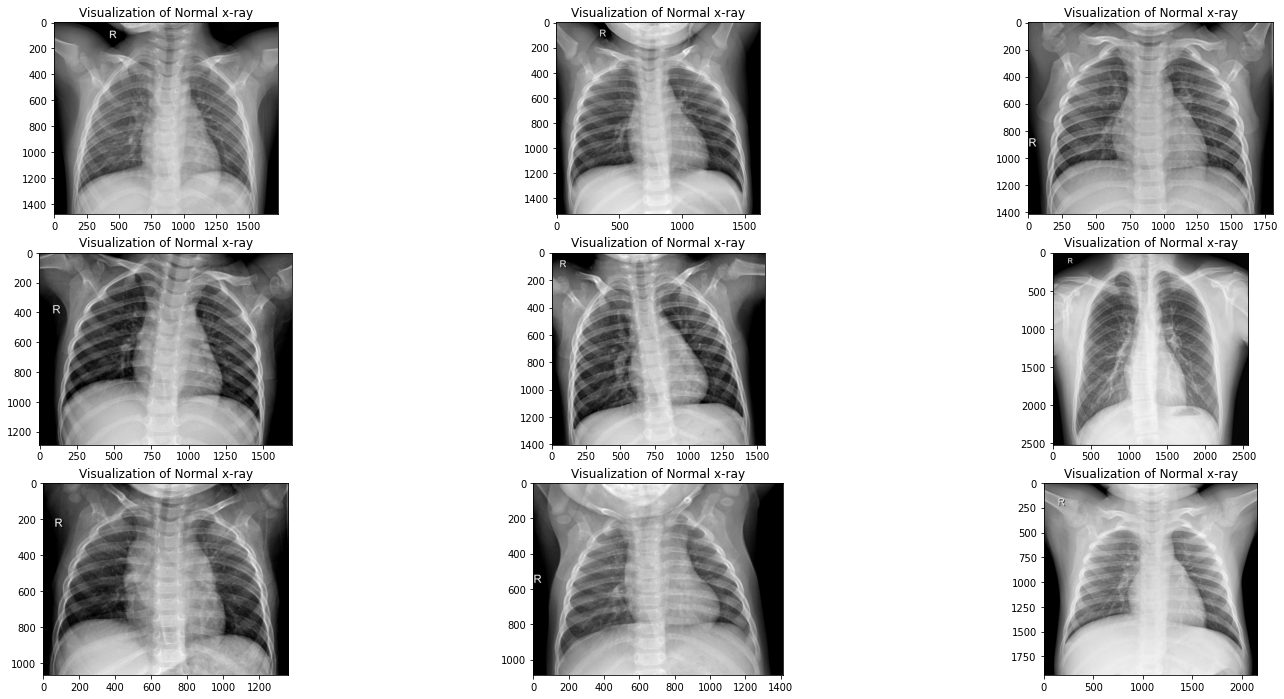

In [7]:
plt.figure(figsize = (25,12))
for i in range(9):
    plt.subplot(3 , 3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.title("Visualization of Normal x-ray")
plt.show()

### Individual visualization

#### Count the number of infected and normal 

/home/nix-code/virtualenv/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

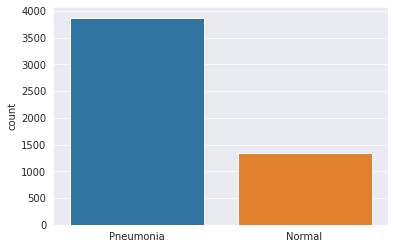

In [8]:
count_me = []
for i in train:
    if(i[1] == 0):
        count_me.append("Pneumonia")
    else:
        count_me.append("Normal")
sns.set_style('darkgrid')
sns.countplot(count_me)     

#### Since, pneumonia is more, and the normal is less , we need to make the data balanced

Text(0.5, 1.0, 'PNEUMONIA')

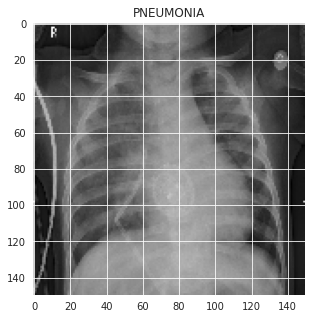

In [9]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0],cmap='gray')
plt.title(labels[train[0][1]])


Text(0.5, 1.0, 'NORMAL')

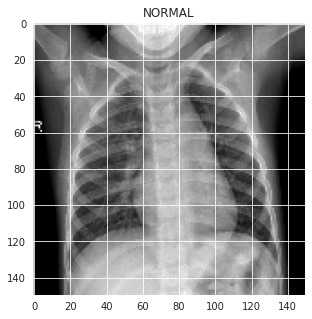

In [10]:
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])


### Preprocessing the data

In [11]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(feature)
    


### Normalization of the data

In [12]:
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)


### Data Augmentation

#### Augmentation helps to prevent overfitting problems

In [13]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,             # zca whitening
    rotation_range = 30,               # rotate the image 
    zoom_range = 0.2,                  # zoom image randomly
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    
    horizontal_flip = True,
    vertical_flip = False
    
)

datagen.fit(x_train)

#### Training with basic CNN

In [14]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())

model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

2022-01-15 22:38:42.487299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 22:38:42.573206: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 22:38:42.573664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-15 22:38:42.575038: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [15]:
rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)


In [16]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 16 ,callbacks = [rate_reduction])

Epoch 1/16


2022-01-15 22:38:47.087195: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


163/163 [==============================] - 19s 79ms/step - loss: 0.6591 - accuracy: 0.8340 - lr: 0.0010
Epoch 2/16
163/163 [==============================] - 13s 82ms/step - loss: 0.2863 - accuracy: 0.8993 - lr: 0.0010
Epoch 3/16
163/163 [==============================] - 13s 78ms/step - loss: 0.2326 - accuracy: 0.9158 - lr: 0.0010
Epoch 4/16
163/163 [==============================] - 13s 78ms/step - loss: 0.2115 - accuracy: 0.9212 - lr: 0.0010
Epoch 5/16
163/163 [==============================] - 13s 78ms/step - loss: 0.2017 - accuracy: 0.9262 - lr: 0.0010
Epoch 6/16
163/163 [==============================] - 13s 78ms/step - loss: 0.1823 - accuracy: 0.9408 - lr: 0.0010
Epoch 7/16
163/163 [==============================] - 13s 79ms/step - loss: 0.1738 - accuracy: 0.9410 - lr: 0.0010
Epoch 8/16
163/163 [==============================] - 13s 79ms/step - loss: 0.1779 - accuracy: 0.9444 - lr: 0.0010
Epoch 9/16
163/163 [==============================] - 13s 79ms/step - loss: 0.1794 - accura

### Loss and Accuracy

In [17]:
score = model.evaluate(x_train, y_train, verbose = 0) 
print('Train loss:', score[0]) 
print('Train accuracy:', score[1])

2022-01-15 22:42:18.779880: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 469440000 exceeds 10% of free system memory.
2022-01-15 22:42:19.503513: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 469440000 exceeds 10% of free system memory.


Train loss: 1.582870364189148
Train accuracy: 0.8565950989723206


In [18]:
scores = model.evaluate(x_test, y_test,verbose=0)
print('Test loss:', scores[0]) 
print('Test accuracy:', scores[1])

Test loss: 14.777528762817383
Test accuracy: 0.6570512652397156


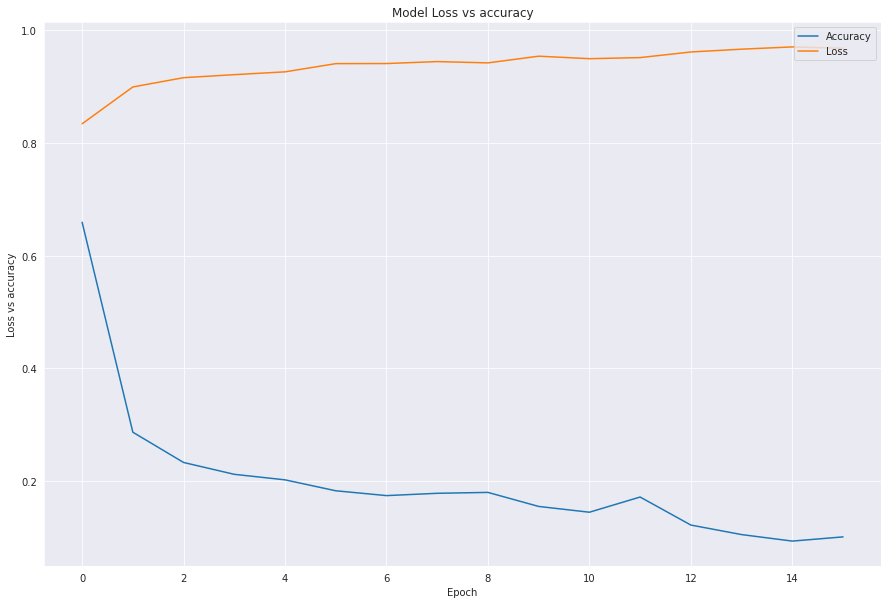

In [19]:
plt.figure(figsize = (15,10))
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Model Loss vs accuracy')
plt.ylabel('Loss vs accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='upper right')
plt.show()


### Model analysis

In [20]:
y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int).reshape(-1)


##### Real vs predicted data

In [21]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [22]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Classification report

In [23]:
print(classification_report(y_test, y_pred, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))


                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.65      1.00      0.78       390
   Normal (Class 1)       1.00      0.09      0.16       234

           accuracy                           0.66       624
          macro avg       0.82      0.54      0.47       624
       weighted avg       0.78      0.66      0.55       624



### Confusion Matrix

In [24]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[390,   0],
       [214,  20]])

In [25]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

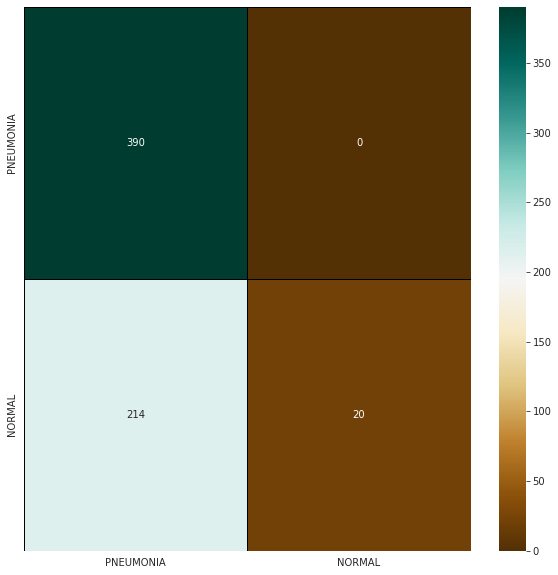

In [26]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "BrBG", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [27]:
correct = np.nonzero(y_pred == y_test)[0]
incorrect = np.nonzero(y_pred != y_test)[0]

#### Correctly predicted

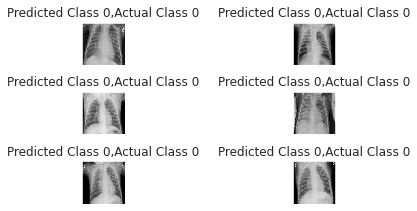

In [28]:
i = 0
for c in correct[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(y_pred[c], y_test[c]))
    plt.tight_layout()
    i += 1

#### Incorrect Predictions

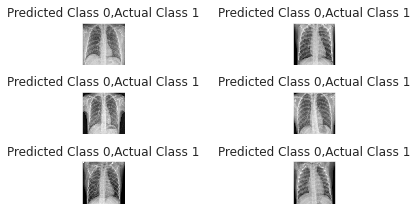

In [29]:
i = 0
for c in incorrect[:6]:
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(y_pred[c], y_test[c]))
    plt.tight_layout()
    i += 1